In [896]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as spatial
from Helpers import helpers, twod_laplace

In [897]:
plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")

In [898]:
plain_df = plain_df.drop(columns=['class'])
plain_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks
0,120.0,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0
1,132.0,4.0,0.0,4.0,2.0,130.0,68.0,198.0,6.0
2,133.0,2.0,0.0,5.0,2.0,130.0,68.0,198.0,5.0
3,134.0,2.0,0.0,6.0,2.0,117.0,53.0,170.0,11.0
4,132.0,4.0,0.0,5.0,0.0,117.0,53.0,170.0,9.0


In [899]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
perturbed_df_2d = perturbed_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [900]:
import random
from sklearn.preprocessing import MinMaxScaler

def get_Z_outside_domain_X(plain_df, perturbed_df):
    """tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask"""
    outside_domain_mask = np.logical_or.reduce([np.logical_or(perturbed_df[:, dim] <= plain_df[:, dim].min(), perturbed_df[:, dim] >= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])
    return outside_domain_mask

def get_radius_and_perturbation(plain_df, epsilon):
    data = {'r': [], 'x': [], 'y': []}
    # loop through each record
    for row in plain_df.values:
        p = random.random()
        theta = np.random.rand()*np.pi*2
        r = twod_laplace.inverseCumulativeGamma(epsilon, p) # draw radius distance
        private_point = twod_laplace.addVectorToPoint(row, r, theta)
        data['r'].append(r)
        data['x'].append(private_point[0])
        data['y'].append(private_point[1])

    return pd.DataFrame(data)

def transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

def inverse_transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.inverse_transform(dataframe), columns=dataframe.columns)



In [901]:
tree = spatial.KDTree(plain_df_2d)
query_data = tree.query_ball_point([132.0,4.0], r=0.3)
plain_df_2d.iloc[query_data]

,baseline value,histogram_min


In [902]:
min_max_scaler = MinMaxScaler(feature_range=[-1,1])
min_max_scaler_perturbed = MinMaxScaler(feature_range=[-1,1])


In [903]:
perturbed_data_with_r = get_radius_and_perturbation(plain_df_2d, 0.5)
perturbed_data_with_r.head()

,r,x,y
0,4.586698,115.935472,64.125419
1,5.405044,127.212005,65.492091
2,0.847766,132.215428,68.321176
3,2.350368,133.109667,55.175210
4,4.095808,130.100817,49.371123


In [904]:
outside_domain_mask = get_Z_outside_domain_X(plain_df_2d.values, perturbed_data_with_r.drop(columns=['r']).values)


In [905]:
perturbed_data_with_r_outside_domain = perturbed_data_with_r.drop(columns=['r'])[outside_domain_mask]
perturbed_data_with_r_outside_domain = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain], axis=1)

In [906]:
perturbed_data_with_r_outside_domain.head()

,r,x,y
4,4.095808,130.100817,49.371123
5,1.284434,133.173247,49.017020
6,5.762912,132.386669,44.467521
28,1.747734,131.414783,48.353156
29,7.181910,139.139513,49.220782


In [907]:
# perturbed_data_with_r_outside_domain_scaled = pd.DataFrame(min_max_scaler.fit_transform(perturbed_data_with_r_outside_domain), columns=perturbed_data_with_r_outside_domain.columns)


In [908]:
random_point = perturbed_data_with_r_outside_domain.iloc[2]
plain_tree = spatial.KDTree(plain_df_2d)
perturbed_query_data = plain_tree.query_ball_point([random_point['x'], random_point['y']], r=random_point['r'])

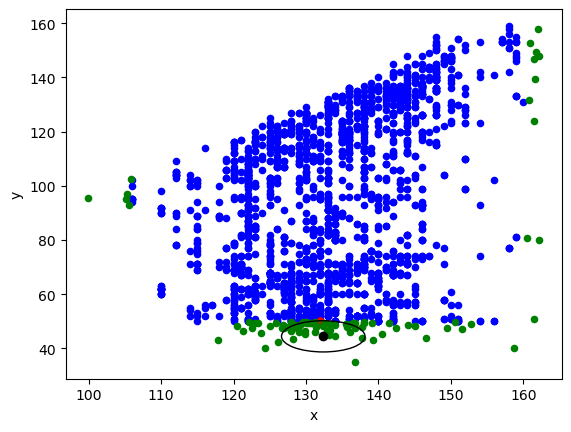

In [909]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
plain_df_2d.iloc[perturbed_query_data].plot(kind='scatter', x='baseline value', y='histogram_min', color='red', ax=ax)
perturbed_data_with_r_outside_domain.plot(kind='scatter', x='x', y='y', color='green', ax=ax)
ax.add_patch(plt.Circle((random_point['x'], random_point['y']), random_point['r'], color='black', fill=False))
ax.scatter(random_point['x'], random_point['y'], color='black')

In [910]:
perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10, columns=['x', 'y'], include_indicator=True)
# perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['baseline value', 'histogram_min'])
perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped = perturbed_data_with_r_remapped[perturbed_data_with_r_remapped['is_remapped']]
print(perturbed_data_with_r_remapped.shape, perturbed_data_with_r_outside_domain_remapped.shape)

(2126, 4) (202, 4)


In [911]:
"""perturbed_data_with_r_outside_domain_remapped = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=True)
perturbed_data_with_r_outside_domain_remapped.head()"""
perturbed_data_with_r_remapped.head()


,r,x,y,is_remapped
0,4.586698,118.000000,62.111111,True
1,5.405044,127.212005,65.492091,False
2,0.847766,132.215428,68.321176,False
3,2.350368,133.109667,55.175210,False
4,4.095808,130.000000,50.000000,True


<AxesSubplot:xlabel='x', ylabel='y'>

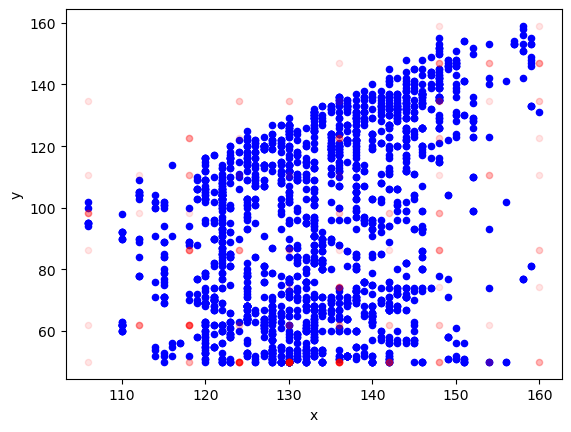

In [912]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)


In [913]:
import math
import scipy.spatial as spatial


def calculate_distance(point1, point2):
    #return spatial.distance.euclidean(point1, point2)  # Euclidean distance as an example
    return np.linalg.norm(point1 - point2)

def remap_point(x, z_popularity, fake_data, real_data, radius, epsilon, plain_tree, w_x):
    w_x = len(w_x) + len(z_popularity)
    #w_q_sum = sum([len(calculate_popularity(q, real_data, radius)) for q in Q_r(x, z, real_data, radius)])
    q = Q_r(x, real_data, radius, plain_tree)
    w_q_sum = len(q)

    # q_calc = (w_q_sum * math.exp(-epsilon * calculate_distance(q, z)))
    #print(w_q_sum)
    distance_xz = calculate_distance(x, fake_data)
    #epsilon_offset = 1e-6  # Small offset to avoid division by zero or infinite results
    
    remapped_value = (w_x * math.exp(-epsilon * distance_xz)) / w_q_sum if w_q_sum > 0 else 0
    
    return remapped_value

def Q_r(x, points, radius, kd_tree=None):
    kdtree = spatial.KDTree(points) if kd_tree is None else kd_tree
    indices = kdtree.query_ball_point((x), radius)
    return [points[i] for i in indices]

def find_new_r_for_perturbed_datas_outside_domain(perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_with_Q = perturbed_data.copy()
    for index, point in perturbed_data_with_Q.iterrows():
        x = plain_df.iloc[index]
        new_r = { 'x_new': [], 'y_new': []}
        for column in ['x', 'y']:
            #print(point[column], x[column])
            polularity_x = Q_r([x[column]], [point[column]], plain_df[column].values, point['r'], plain_tree)
            #new_r[f"{column}_new"].append(remap_point([plain_df.loc[index,column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            for x_q in polularity_x:
                print(x_q)
                new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))

            coefficients = [x_new * x[column] for x_new in new_r[f"{column}_new"]] 
            sum_coefficients = sum(coefficients)
            
            probabilities = [coeff / sum_coefficients for coeff in coefficients]
            if(sum_coefficients > 0): 
                averaged = np.average(polularity_x, axis=0, weights=probabilities)
                averaged = averaged if averaged is not np.nan else point[column]
                perturbed_data_with_Q.loc[index, f"{column}_new"] = averaged
            else:
                perturbed_data_with_Q.loc[index, f"{column}_new"] = point[column]
        
    return perturbed_data_with_Q; 

In [914]:
plain_df_2d.head()
plain_df_2d_renamed = plain_df_2d.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=False)
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [915]:
# counts = find_new_r_for_perturbed_datas_outside_domain(perturbed_data_with_r_outside_domain_remapped.drop(columns=['is_remapped']), plain_df_2d_renamed, epsilon=0.5)

#counts = counts.where(counts['Q_r'] > 0).dropna()

In [916]:
counts.head()

,r,x,y,x_new,y_new
6,5.619434,130.0,50.000000,134.753120,50.000000
10,8.327530,160.0,62.111111,149.132622,62.111111
18,10.423892,130.0,50.000000,124.108484,50.000000
28,5.577380,136.0,50.000000,135.000000,50.000000
29,8.650846,130.0,50.000000,134.302909,50.000000


In [917]:
print(counts['y_new'].max(), plain_df_2d_renamed['y'].max(), counts['y_new'].min(), plain_df_2d_renamed['y'].min(), perturbed_data_with_r_outside_domain_remapped['y'].max(), perturbed_data_with_r_outside_domain_remapped['y'].min())
print(counts['x_new'].max(), plain_df_2d_renamed['x'].max(), counts['x_new'].min(), plain_df_2d_renamed['x'].min(), perturbed_data_with_r_outside_domain_remapped['x'].max(), perturbed_data_with_r_outside_domain_remapped['x'].min())

159.0 159.0 50.0 50.0 159.0 50.0
160.0 160.0 106.0 106.0 160.0 106.0


In [918]:
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


$$  \sigma(x) = \frac{w(x)e^{-\epsilon d(x, z)}}{w(q)e^{-\epsilon d(q, z)}}$$

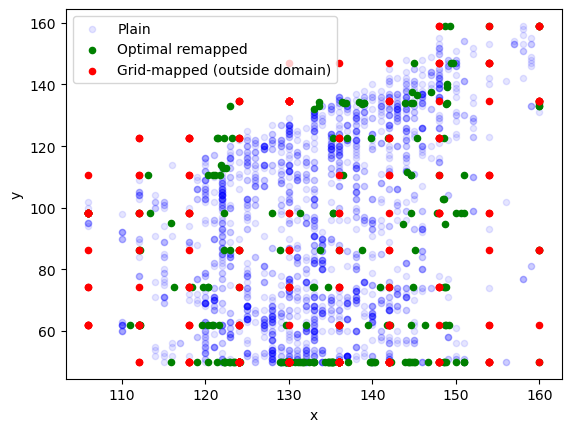

In [919]:
fig, ax = plt.subplots()
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)

counts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)
counts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])

In [920]:
def get_Z_outside_domain_X(plain_df, perturbed_df):
    # tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    # _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask

"""
    Optimal remapping algoritm.
    Important: Should have a "r" (radius/ radial distance) which is used to remap the data.
    @param perturbed_data: The perturbed data to be remapped. It should be grid-mapped already.
    @param plain_df: The plain data to be used for remapping. (Used to determine crowdness)
"""
def optimal_remapping (perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_copy = perturbed_data.copy()
    if perturbed_data.columns.isin(['is_remapped']).any():
        perturbed_data_copy = perturbed_data_copy[perturbed_data_copy['is_remapped']]
        perturbed_data_copy = perturbed_data_copy.drop(columns=['is_remapped'])
    if not perturbed_data_copy.columns.isin(['r']).any():
        raise ValueError("Perturbed data should have a column named 'r' which is the radius of the grid.")
    if not perturbed_data_copy.shape[1] -1 is plain_df.shape[1]:
        raise ValueError("Perturbed data should have the same number of columns as plain data.")
    if not perturbed_data_copy.columns.drop(labels=['r']).isin(plain_df.columns).all():
        raise ValueError("Perturbed data should have the same columns as plain data.")

    
    ##truncated_perturbed_data = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_copy, epsilon)
    for index, private_data_point in perturbed_data_copy.iterrows(): # loop through each point outside the domain
        non_private_data_point = plain_df.iloc[index] # get the corresponding plain data point
        list_sigma = []
        #print(non_private_data_point, private_data_point)
        # calculate w_x
        polularity_x = Q_r(non_private_data_point.values, plain_df.values, private_data_point['r'], tree)
        popularity_z = Q_r(private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], tree)
        # for every point in a radius r around the non-private data point, calculate the new r.
        for x_q in polularity_x:
            #print(x_q)
            # new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            list_sigma.append(remap_point(x_q, popularity_z, private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], epsilon, tree, w_x=polularity_x))

        coefficients = [x_new * non_private_data_point for x_new in list_sigma] 
        #print(coefficients)
        sum_coefficients = sum(coefficients)
        
        probabilities = np.array([coeff / sum_coefficients for coeff in coefficients]) # calculate the probabilities using the coefficients
        if(sum_coefficients[sum_coefficients > 0].all()):
            perturbed_data_copy.loc[index, plain_df.columns] = np.average(polularity_x, axis=0, weights=probabilities) # calculate the new value for the point based on the average with weightes probabilities.
        #print(np.array(probabilities))

    return perturbed_data_copy

In [921]:
#perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10)
#perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['x', 'y'])
#perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_remapped.head()

,r,x,y,is_remapped
0,4.586698,118.000000,62.111111,True
1,5.405044,127.212005,65.492091,False
2,0.847766,132.215428,68.321176,False
3,2.350368,133.109667,55.175210,False
4,4.095808,130.000000,50.000000,True


In [922]:
optimal_remapped_data = optimal_remapping(perturbed_data_with_r_remapped, plain_df_2d_renamed, epsilon=0.5)

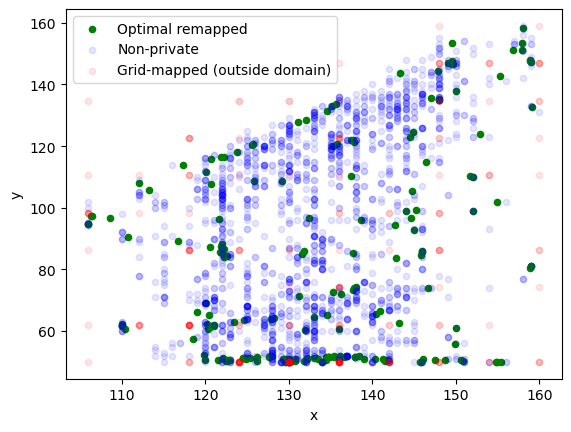

In [988]:
fig, ax = plt.subplots()
optimal_remapped_data.plot(kind='scatter', x='x', y='y', color='green', ax=ax, alpha=1)
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)
ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])

In [924]:
plain_df_2d_renamed.min()

x    106.0
y     50.0
dtype: float64

In [984]:
def mechanism_design(plain_df, perturbed_df, grid_size=10, columns=['x', 'y'], epsilon=0.1):
    perturbed_df_with_grid_remapping = helpers.truncate_n_dimensional_laplace_noise(perturbed_df.drop(columns=['r']).values, plain_df.values, grid_size=grid_size, columns=columns, include_indicator=True)
    #perturbed_df_find_grid_remappings = perturbed_df_with_grid_remapping[perturbed_df_with_grid_remapping['is_remapped']]
    perturbed_df_find_grid_remappings_with_r = pd.concat([perturbed_df['r'], perturbed_df_with_grid_remapping], axis=1)
    perturbed_df_optimal_remapping = optimal_remapping(perturbed_df_find_grid_remappings_with_r, plain_df, epsilon=epsilon)
    return perturbed_df_optimal_remapping

In [926]:
perturbed_df_optimal_remapping = mechanism_design(plain_df_2d_renamed, perturbed_data_with_r)

<AxesSubplot:xlabel='x', ylabel='y'>

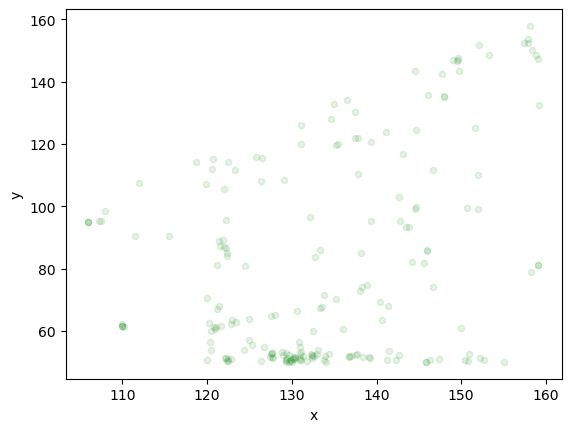

In [927]:
perturbed_df_optimal_remapping.plot(kind='scatter', x='x', y='y', color='green', alpha=0.1)

## 3D Variant

In [928]:
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d = perturbed_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d.head()

,baseline value,histogram_min,accelerations
0,143.085375,62.000007,-1.574761
1,156.148066,67.998066,6.570822
2,151.820138,68.002038,-0.495178
3,161.102637,52.999833,6.539972
4,148.282493,53.002594,9.905883


In [929]:
from Helpers import threed_laplace

epsilon = 0.5

In [930]:
def generate_3D_noise_for_dataset(plain_df:pd.DataFrame, epsilon):
    Z = []
    R = []
    X = np.array(plain_df)
    for x in X: 
        noise = generate_3D_noise(epsilon)
        z = x + noise[:3]
        Z.append(z)
        R.append(noise[3])
    return pd.concat((pd.DataFrame(Z, columns=plain_df.columns), pd.DataFrame(R, columns=['r'])), axis=1)
def generate_3D_noise(epsilon): 
    polar_angle, azimuth, _ = threed_laplace.generate_unit_sphere() # theta, psi
    r = threed_laplace.generate_r(epsilon)
    # theta = 2 * np.pi * u[0]
    #theta = np.random.rand() * np.pi
    #phi = np.arccos(2 * u[1] - 1)
    #phi = np.random.rand() * np.pi*2 # 
    # https://mathworld.wolfram.com/SphericalCoordinates.html formula 4/5/6
    x = r * np.sin(polar_angle) * np.sin(azimuth)
    y = r * np.sin(polar_angle) * np.cos(azimuth)
    z = r * np.cos(polar_angle)
    return x, y, z, r

In [931]:
perturbed_df_3d = generate_3D_noise_for_dataset(plain_df_3d, epsilon)
#perturbed_df_3d = pd.DataFrame(perturbed_df_3d, columns=['baseline value', 'histogram_min', 'accelerations'])
perturbed_df_3d.head()

,baseline value,histogram_min,accelerations,r
0,125.445579,64.329182,0.939524,5.996843
1,130.417047,67.643050,-5.708694,9.843368
2,135.563073,69.976759,6.064508,5.195877
3,134.127673,52.835401,-3.021074,5.025393
4,131.771243,52.673581,16.272686,12.279157


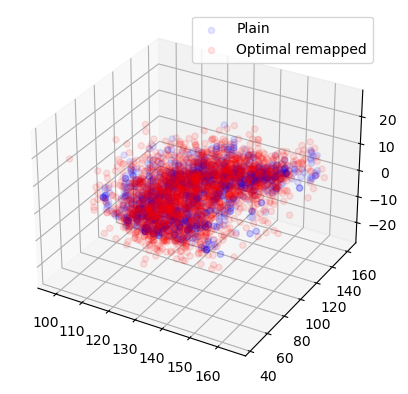

In [985]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)
ax.scatter3D(perturbed_df_3d['baseline value'], perturbed_df_3d['histogram_min'], perturbed_df_3d['accelerations'], color='red', alpha=0.1)
#plain_df_3d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])

In [971]:
perturbed_df_3d_grid_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_df_3d.drop(columns=['r']).values, plain_df_3d.values, grid_size=10, columns=['baseline value', 'histogram_min', 'accelerations'], include_indicator=True)
perturbed_df_3d_outside_domain = perturbed_df_3d[perturbed_df_3d_grid_remapped['is_remapped']]
print(perturbed_df_3d_outside_domain.shape, perturbed_df_3d_grid_remapped.shape)

(1045, 4) (2126, 4)


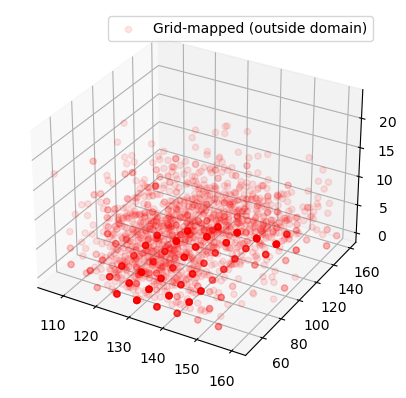

In [994]:
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter3D(perturbed_df_3d_outside_domain['baseline value'], perturbed_df_3d_outside_domain['histogram_min'], perturbed_df_3d_outside_domain['accelerations'], color='blue', alpha=0.1)
#ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='green', alpha=0.1)
ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
ax.legend(['Grid-mapped (outside domain)'])
#ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
#perturbed_df_3d_grid_remapped.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)

In [963]:
perturbed_df_remapped = mechanism_design(plain_df_3d, perturbed_df_3d, epsilon=0.5, columns=plain_df_3d.columns)

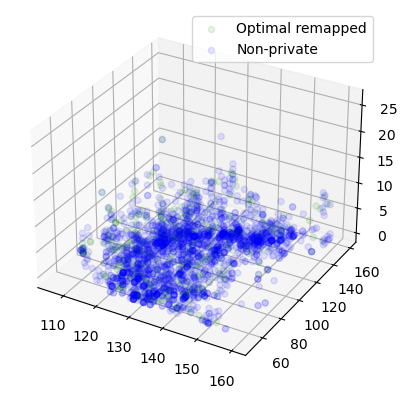

In [995]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(perturbed_df_remapped['baseline value'], perturbed_df_remapped['histogram_min'], perturbed_df_remapped['accelerations'], color='green', alpha=1)
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)

ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])
